In [1]:
# Nash Cascade Neural Network
# A hydrologically intuitive deep learning network

# Set up a solution to a network of buckets where the number of buckets in each layer
# flows out to the buckets in the next layer
# The parameter on each bucket is the size and height of each spigot.

# Need a function that solves this individually at a single buckets
# Then a function that loops through and moves the water to the downstream buckets

In [2]:
import torch
import copy
import matplotlib.pyplot as plt
from ncnn import NashCascadeNeuralNetwork as ncnn
from ncnn import train_model as train_ncnn
from ncn import NashCascadeNetwork as ncn
# Precipitation standard variable name used in the ncnn model interface
PRECIP_SVN = "atmosphere_water__liquid_equivalent_precipitation_rate"
PRECIP_SVN_SEQ = "atmosphere_water__liquid_equivalent_precipitation_rate_seq"
DO_PLOT = True
N_TIMESTEPS = 600

In [3]:
network_precip_input_list = []
count = 0
for i in range(N_TIMESTEPS):

    ###########################################################################
    if count == 0:
        network_precip_input_list.append(1.0)
    elif count > 39:
        network_precip_input_list.append(3.0)
    else:
        network_precip_input_list.append(0.0)
    if count == 50:
        count = 0
    count+=1
    ###########################################################################
network_precip_tensor = torch.tensor(network_precip_input_list, requires_grad=False)
total_mass_precip_in = torch.sum(network_precip_tensor)

Initial Mass in network at start: 50.0
Initial Mass in network: 50.0
Final Mass in network: 18.2
Total Mass out of network 425.8
Total precipitation into network 394.0
Mass balance for network is 0.000
Mass balance for network is 0.000


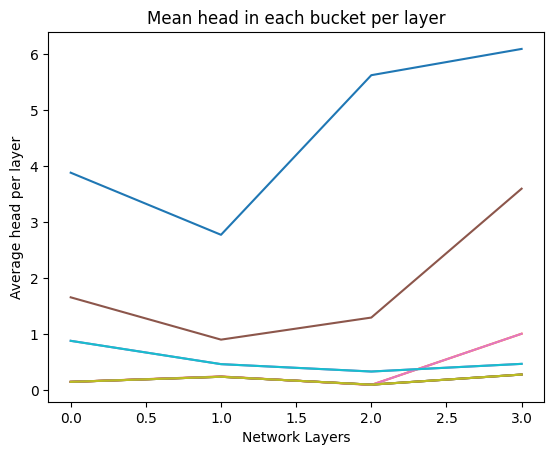

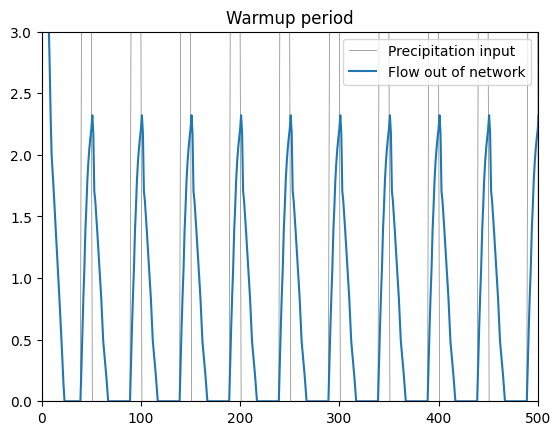

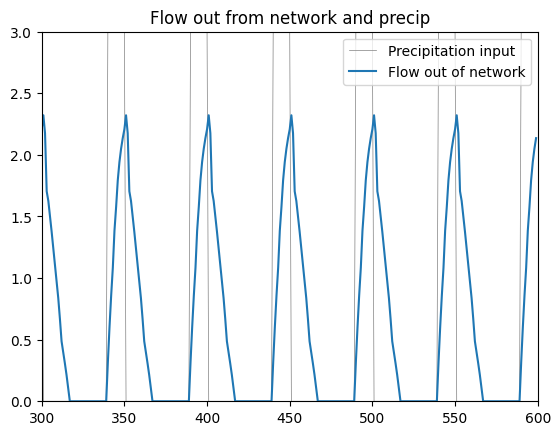

In [4]:
# Example 0
bucket_net = ncn(cfg_file="./config_0.json")
bucket_net.initialize()
bucket_net.summarize_network()
inital_mass_in_network = torch.sum(torch.tensor([tensor.item() for tensor in bucket_net.sum_H_per_layer]))
print(f"Initial Mass in network at start: {inital_mass_in_network:.1f}")
network_outflow_list_0 = []
for i in range(N_TIMESTEPS):

    ###########################################################################
    ###########################################################################
    bucket_net.set_value(PRECIP_SVN, torch.tensor(network_precip_input_list[i], requires_grad=True))
    bucket_net.forward()
    network_outflow_list_0.append(bucket_net.network_outflow.item())
    bucket_net.summarize_network()
    ###########################################################################
    ###########################################################################

    if DO_PLOT:
        if i % int(N_TIMESTEPS/10) == 0:
            plt.plot([tensor.item() for tensor in bucket_net.mean_H_per_layer])

network_outflow_tensor_0 = torch.tensor(network_outflow_list_0, requires_grad=True)
bucket_net.report_out_mass_balance()
bucket_net.detach_ncn_from_graph()
bucket_net.theta.detach()

if DO_PLOT:
    plt.title("Mean head in each bucket per layer")
    plt.ylabel("Average head per layer")
    plt.xlabel("Network Layers")
    plt.show()
    plt.close()

if DO_PLOT:
    startplt = 0
    endplt = 500

    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list[startplt:endplt])).item()])
    plt.legend()
    plt.title("Warmup period")
    plt.show()
    plt.close()
    startplt = int(len(network_outflow_list_0)-(len(network_outflow_list_0)/2))
    endplt = int(len(network_outflow_list_0))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list[startplt:endplt])).item()])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

Initial Mass in network at start: 50.0
Initial Mass in network: 50.0
Final Mass in network: 11.7
Total Mass out of network 432.3
Total precipitation into network 394.0
Mass balance for network is 0.000
Mass balance for network is 0.000


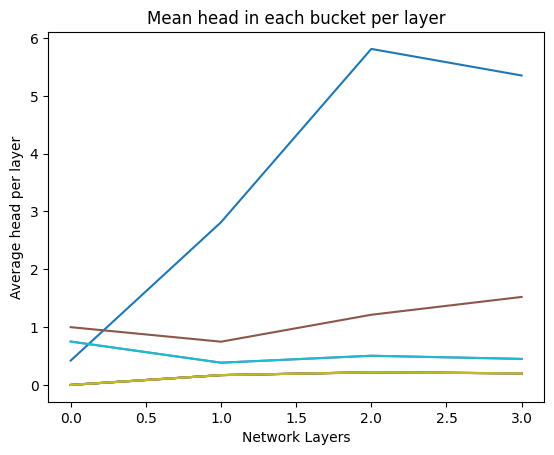

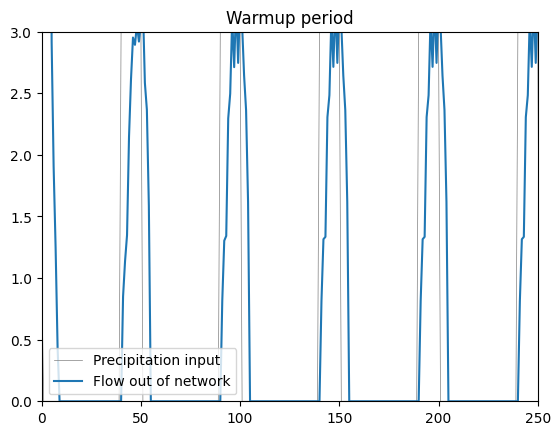

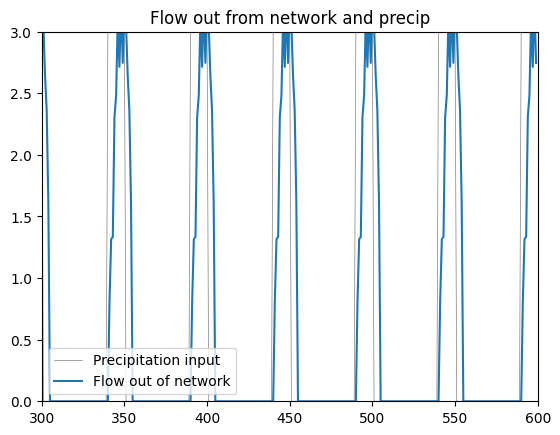

In [5]:
# Example 1
bucket_nn = ncnn(cfg_file="./config_1.json")
bucket_nn.ncn.initialize_theta_values()
inital_mass_in_network = torch.sum(torch.stack(bucket_nn.ncn.sum_H_per_layer)).item()
print(f"Initial Mass in network at start: {inital_mass_in_network:.1f}")
network_outflow_list_1 = []
for i in range(N_TIMESTEPS):

    ###########################################################################
    ###########################################################################
    bucket_nn.ncn.set_value(PRECIP_SVN, torch.tensor(network_precip_input_list[i], requires_grad=True))
    if bucket_nn.ncn.do_predict_theta_with_lstm:
        sequence_tensors = []
        tensor_device = bucket_nn.ncn.network[0]['H'].device
        tensor_dtype = torch.float32
        if i >= bucket_nn.ncn.input_u_sequence_length:
            sequence_tensors = [torch.tensor([item], device=tensor_device, dtype=tensor_dtype) 
                                for item in network_precip_input_list[i-bucket_nn.ncn.input_u_sequence_length:i]]
        else:
            desired_tensor_shape = (1,)
            padding_size = bucket_nn.ncn.input_u_sequence_length - i
            padding_tensors = [torch.zeros(desired_tensor_shape, device=tensor_device, dtype=tensor_dtype) 
                            for _ in range(padding_size)]
            sequence_tensors = padding_tensors + [torch.tensor([item], device=tensor_device, dtype=tensor_dtype) 
                                                for item in network_precip_input_list[:i]]
        sequence = torch.stack(sequence_tensors).view(1, -1)
        bucket_nn.ncn.set_value(PRECIP_SVN_SEQ, sequence)


    bucket_nn.ncn.forward()
    network_outflow_list_1.append(bucket_nn.ncn.network_outflow.item())
    bucket_nn.ncn.summarize_network()
    ###########################################################################
    ###########################################################################

    if DO_PLOT:
        if i % int(N_TIMESTEPS/10) == 0:
            plt.plot([tensor.item() for tensor in bucket_nn.ncn.mean_H_per_layer])

###########################################################################
network_outflow_tensor_1 = torch.tensor(network_outflow_list_1, requires_grad=True)
bucket_nn.ncn.report_out_mass_balance()

origional_bucket_theta = copy.deepcopy(bucket_nn.ncn.theta.detach())

if DO_PLOT:
    plt.title("Mean head in each bucket per layer")
    plt.ylabel("Average head per layer")
    plt.xlabel("Network Layers")
    plt.show()
    plt.close()

if DO_PLOT:
    startplt = 0
    endplt = 250

    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_1, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list)[startplt:endplt]).item()])
    plt.legend()
    plt.title("Warmup period")
    plt.show()
    plt.close()
    startplt = int(len(network_outflow_list_1)-(len(network_outflow_list_1)/2))
    endplt = int(len(network_outflow_list_1))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_1, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list)[startplt:endplt]).item()])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

In [6]:
DO_PLOT = True

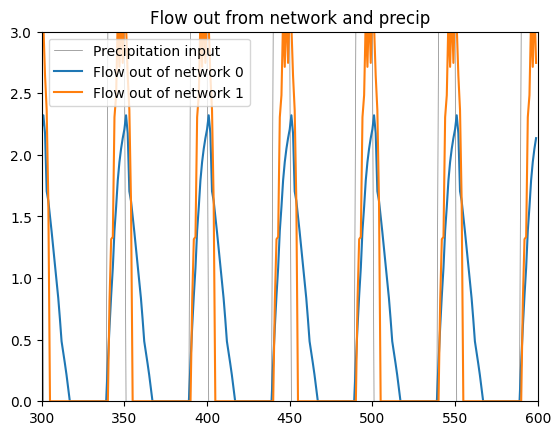

In [7]:
if DO_PLOT:
    startplt = int(len(network_outflow_list_1)-(len(network_outflow_list_1)/2))
    endplt = int(len(network_outflow_list_1))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network 0")
    plt.plot(network_outflow_list_1, label="Flow out of network 1")
    plt.xlim([startplt, endplt])
    max_value = torch.max(network_precip_tensor[startplt:endplt]).item()
    plt.ylim([0, max_value])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

In [8]:
network_precip_tensor.shape, network_outflow_tensor_0.shape

(torch.Size([600]), torch.Size([600]))

In [9]:
len(network_outflow_list_0)

600

In [10]:
y_pred, loss = train_ncnn(bucket_nn, network_precip_tensor, network_outflow_tensor_0)
network_outflow_list_1 = list(y_pred.detach().numpy())
print(bucket_net.theta)
print(bucket_net.theta.grad)
print(bucket_nn.ncn.theta)
print(bucket_nn.ncn.theta.grad)

Adjusting learning rate of group 0 to 1.0000e+01.
loss: 0.3612
Adjusting learning rate of group 0 to 1.0000e+01.
loss: 0.3611
Adjusting learning rate of group 0 to 7.5000e+00.
loss: 0.3592
Adjusting learning rate of group 0 to 7.5000e+00.
loss: 0.3001
Adjusting learning rate of group 0 to 5.6250e+00.
loss: 0.0458
Adjusting learning rate of group 0 to 5.6250e+00.
loss: 0.0467
Adjusting learning rate of group 0 to 4.2188e+00.
loss: 0.0463
Adjusting learning rate of group 0 to 4.2188e+00.
loss: 0.0457
Adjusting learning rate of group 0 to 3.1641e+00.
loss: 0.0420
Adjusting learning rate of group 0 to 3.1641e+00.
loss: 0.0401
Adjusting learning rate of group 0 to 2.3730e+00.
loss: 0.0387
Adjusting learning rate of group 0 to 2.3730e+00.
loss: 0.0376
Adjusting learning rate of group 0 to 1.7798e+00.
loss: 0.0363
Adjusting learning rate of group 0 to 1.7798e+00.
loss: 0.0353
Adjusting learning rate of group 0 to 1.3348e+00.
loss: 0.0342
Adjusting learning rate of group 0 to 1.3348e+00.
loss:

/tmp/ipykernel_20842/4120477293.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  print(bucket_nn.ncn.theta.grad)


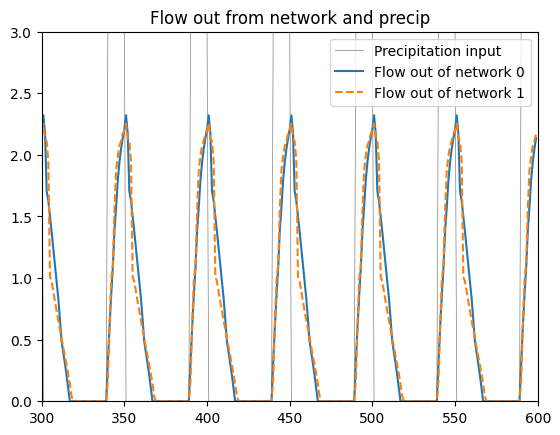

In [11]:
if DO_PLOT:
    startplt = int(len(network_outflow_list_1)-(len(network_outflow_list_1)/2))
    endplt = int(len(network_outflow_list_1))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network 0")
    plt.plot(network_outflow_list_1, "--", label="Flow out of network 1")
    plt.xlim([startplt, endplt])
    network_precip_tensor = torch.tensor(network_precip_input_list)
    max_value = torch.max(network_precip_tensor[startplt:endplt]).item()
    plt.ylim([0, max_value])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

In [12]:
bucket_net.network

{0: {'H': tensor([1.6503]),
  'S': tensor([[[0.8203, 0.8085],
           [0.1559, 0.1941],
           [0.9156, 0.1167]]]),
  's_q': tensor([[0.4565, 0.2291, 0.0569]])},
 1: {'H': tensor([1.2545, 0.9404, 0.5019]),
  'S': tensor([[[0.1028, 0.5114],
           [0.6505, 0.0057],
           [0.7905, 0.6785]],
  
          [[0.8577, 0.6769],
           [0.6840, 0.5676],
           [0.7260, 0.4092]],
  
          [[0.5589, 0.8050],
           [0.5424, 0.9662],
           [0.0411, 0.1578]]]),
  's_q': tensor([[0.5239, 0.0018, 0.1783],
          [0.3444, 0.1335, 0.0000],
          [0.2731, 0.0000, 0.0328]])},
 2: {'H': tensor([2.3452, 0.8205, 0.7028]),
  'S': tensor([[[0.0759, 0.8638],
           [0.7971, 0.2944],
           [0.1679, 0.0751]],
  
          [[0.7565, 0.1038],
           [0.8114, 0.1082],
           [0.0353, 0.4700]],
  
          [[0.2258, 0.4063],
           [0.4060, 0.8211],
           [0.3024, 0.9550]]]),
  's_q': tensor([[1.2120, 0.1307, 0.0434],
          [0.0660, 0.0000, 0

In [13]:
bucket_nn.ncn.network

{0: {'H': tensor([1.0012]),
  'S': tensor([[[0.7576, 0.2793],
           [0.4031, 0.7347],
           [0.0293, 0.7999]]]),
  's_q': tensor([[0.1819, 0.2926, 0.2755]])},
 1: {'H': tensor([0.5709, 0.8757, 0.8014]),
  'S': tensor([[[0.3971, 0.7544],
           [0.5695, 0.4388],
           [0.6387, 0.5247]],
  
          [[0.6826, 0.3051],
           [0.4635, 0.4550],
           [0.5725, 0.4980]],
  
          [[0.9371, 0.6556],
           [0.3138, 0.1980],
           [0.4162, 0.2843]]]),
  's_q': tensor([[0.4317, 0.0000, 0.0000],
          [0.3156, 0.2271, 0.0000],
          [0.5256, 0.0000, 0.0000]])},
 2: {'H': tensor([2.0598, 0.6454, 0.6576]),
  'S': tensor([[[0.3398, 0.5239],
           [0.7981, 0.7718],
           [0.0112, 0.8100]],
  
          [[0.6397, 0.9743],
           [0.8300, 0.0444],
           [0.0246, 0.2588]],
  
          [[0.9391, 0.4167],
           [0.7140, 0.2676],
           [0.9906, 0.2885]]]),
  's_q': tensor([[0.6494, 0.3897, 0.4838],
          [0.4772, 0.0000, 0

In [14]:
bucket_net.theta

tensor([0.1017, 0.2376, 0.1777, 0.2190, 0.1756, 0.2185, 0.1594, 0.1996, 0.2044,
        0.2419, 0.1392, 0.1494, 0.2418, 0.1802, 0.1745, 0.2168, 0.2271, 0.1721,
        0.2443, 0.1642, 0.2090, 0.2021, 0.2233, 0.1333], requires_grad=True)

In [15]:
bucket_nn.ncn.theta

tensor([0.4407, 0.4701, 0.4527, 0.5163, 0.4537, 0.4694, 0.4436, 0.4662, 0.4725,
        0.5525, 0.4955, 0.5239, 0.4410, 0.5541, 0.5047, 0.4513, 0.5333, 0.4779,
        0.5796, 0.4506, 0.4489, 0.1203, 0.5235, 0.4623],
       grad_fn=<SelectBackward0>)

In [16]:
origional_bucket_theta

tensor([0.4416, 0.4815, 0.4624, 0.5215, 0.4543, 0.4738, 0.4653, 0.4667, 0.4759,
        0.5569, 0.4971, 0.5259, 0.4517, 0.5384, 0.4896, 0.4649, 0.5387, 0.4830,
        0.5471, 0.4644, 0.4456, 0.4666, 0.5286, 0.4902])

In [17]:
torch.sum(bucket_nn.ncn.theta - origional_bucket_theta)

tensor(-0.4270, grad_fn=<SumBackward0>)

In [18]:
bucket_nn.ncn.theta - origional_bucket_theta

tensor([-0.0009, -0.0114, -0.0097, -0.0053, -0.0006, -0.0044, -0.0217, -0.0005,
        -0.0034, -0.0043, -0.0017, -0.0021, -0.0107,  0.0157,  0.0151, -0.0136,
        -0.0054, -0.0051,  0.0325, -0.0138,  0.0034, -0.3463, -0.0051, -0.0279],
       grad_fn=<SubBackward0>)

tensor([0.4415, 0.4793, 0.4624, 0.5211, 0.4542, 0.4732, 0.4642, 0.4698, 0.4747,
        0.5565, 0.4939, 0.5234, 0.4510, 0.5421, 0.4942, 0.4581, 0.5381, 0.4812,
        0.5482, 0.4643, 0.4459, 0.1605, 0.5240, 0.4758],
       grad_fn=<SelectBackward0>)
tensor([0.0000, 0.1874, 0.1504, 0.1820, 0.0000, 0.0000, 0.6655, 0.8460, 0.0000,
        0.0000])
tensor([0.4409, 0.4702, 0.4527, 0.5164, 0.4535, 0.4690, 0.4439, 0.4661, 0.4722,
        0.5526, 0.4949, 0.5240, 0.4409, 0.5538, 0.5053, 0.4513, 0.5328, 0.4779,
        0.5796, 0.4503, 0.4490, 0.1205, 0.5234, 0.4623],
       grad_fn=<SelectBackward0>)
tensor([1.0012, 0.5710, 0.8756, 0.8013, 2.0601, 0.6452, 0.9076, 9.3933, 0.8479,
        1.0601])
Initial Mass in network: 50.0
Final Mass in network: 17.4
Total Mass out of network 20520.5
Total precipitation into network 20488.0
Mass balance for network is 0.094
Mass balance for network is 0.094


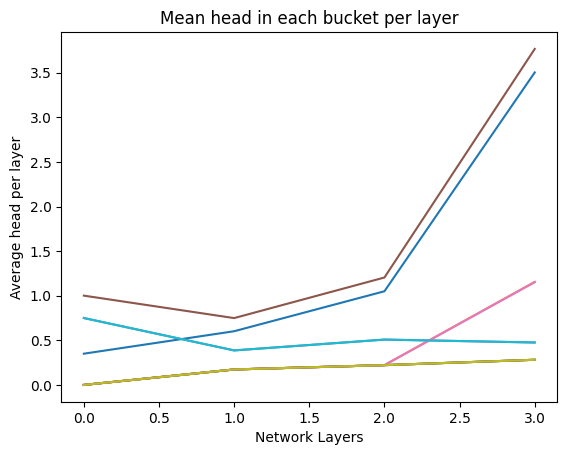

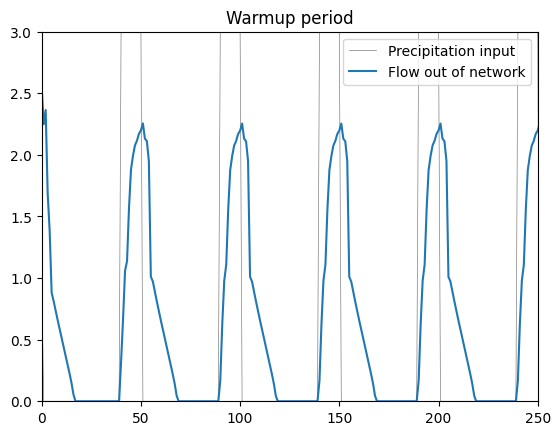

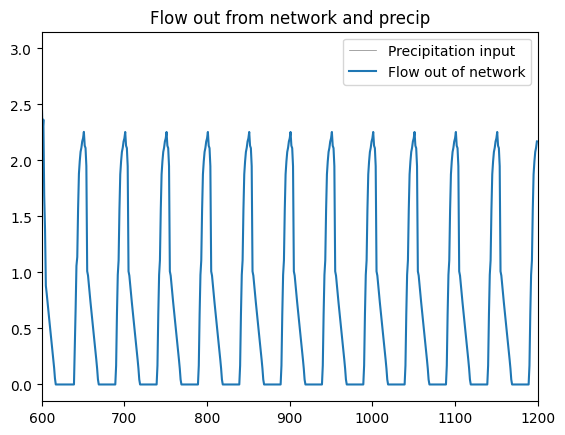

In [19]:
for i in range(N_TIMESTEPS):

    ###########################################################################
    ###########################################################################
    bucket_nn.ncn.set_value(PRECIP_SVN, torch.tensor(network_precip_input_list[i], requires_grad=True))
    if bucket_nn.ncn.do_predict_theta_with_lstm:
        sequence_tensors = []
        tensor_device = bucket_nn.ncn.network[0]['H'].device
        tensor_dtype = torch.float32
        if i >= bucket_nn.ncn.input_u_sequence_length:
            sequence_tensors = [torch.tensor([item], device=tensor_device, dtype=tensor_dtype) 
                                for item in network_precip_input_list[i-bucket_nn.ncn.input_u_sequence_length:i]]
        else:
            desired_tensor_shape = (1,)
            padding_size = bucket_nn.ncn.input_u_sequence_length - i
            padding_tensors = [torch.zeros(desired_tensor_shape, device=tensor_device, dtype=tensor_dtype) 
                            for _ in range(padding_size)]
            sequence_tensors = padding_tensors + [torch.tensor([item], device=tensor_device, dtype=tensor_dtype) 
                                                for item in network_precip_input_list[:i]]
        sequence = torch.stack(sequence_tensors).view(1, -1)
        bucket_nn.ncn.set_value(PRECIP_SVN_SEQ, sequence)


    bucket_nn.ncn.forward()
    network_outflow_list_1.append(bucket_nn.ncn.network_outflow.item())
    bucket_nn.ncn.summarize_network()

    if i in [180, 200]:
        print(bucket_nn.ncn.theta)
        print(bucket_nn.ncn.get_the_H_tensor())
    ###########################################################################
    ###########################################################################

    if DO_PLOT:
        if i % int(N_TIMESTEPS/10) == 0:
            plt.plot([tensor.item() for tensor in bucket_nn.ncn.mean_H_per_layer])

###########################################################################
network_outflow_tensor_1 = torch.tensor(network_outflow_list_1, requires_grad=True)
bucket_nn.ncn.report_out_mass_balance()

origional_bucket_theta = copy.deepcopy(bucket_nn.ncn.theta.detach())

if DO_PLOT:
    plt.title("Mean head in each bucket per layer")
    plt.ylabel("Average head per layer")
    plt.xlabel("Network Layers")
    plt.show()
    plt.close()

if DO_PLOT:
    startplt = 0
    endplt = 250

    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_1, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list)[startplt:endplt]).item()])
    plt.legend()
    plt.title("Warmup period")
    plt.show()
    plt.close()
    startplt = int(len(network_outflow_list_1)-(len(network_outflow_list_1)/2))
    endplt = int(len(network_outflow_list_1))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_1, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

In [20]:
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable 
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA device: ", torch.cuda.get_device_name(0))
else:
    device = 'cpu'

Using CUDA device:  NVIDIA GeForce RTX 3090


/home/jonat/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 loss: 0.05358409509062767
epoch: 1 loss: 0.00554365711286664
epoch: 2 loss: 0.04167550429701805
epoch: 3 loss: 0.017746159806847572
epoch: 4 loss: 0.009651546366512775
Final loss: 0.009651546366512775


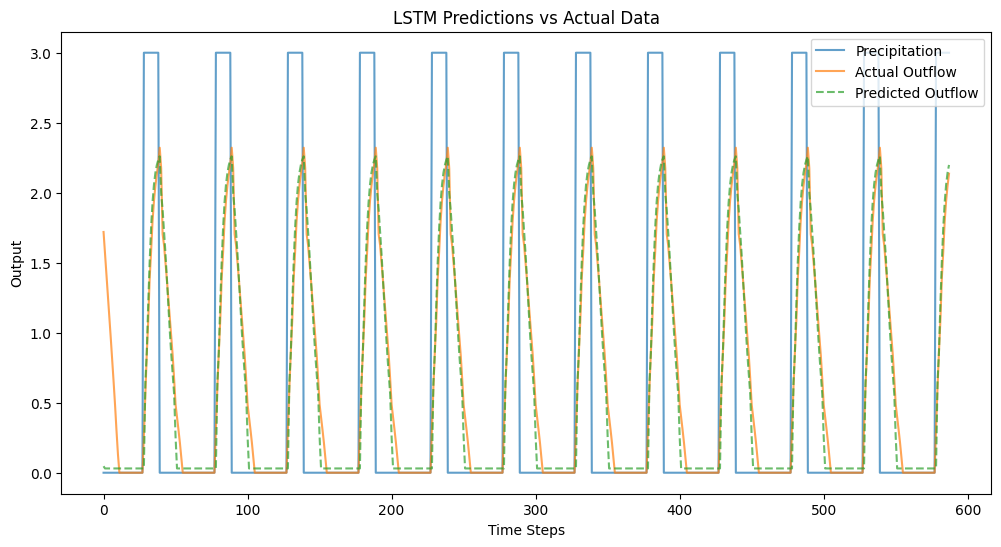

In [21]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Convert arrays to PyTorch tensors
x_input = torch.FloatTensor(network_precip_tensor.detach().numpy())
y_target = torch.FloatTensor(network_outflow_tensor_0.detach().numpy())

# Define the sequence length (you can adjust this)
seq_length = 12

# Function to create sequences
def create_sequences(input_data, target_data, seq_length):
    xs, ys = [], []
    for i in range(len(input_data)-seq_length):
        x_seq = input_data[i:i+seq_length]
        y_seq = target_data[i+seq_length]
        xs.append(x_seq)
        ys.append(y_seq)
    return torch.stack(xs), torch.stack(ys)

X, y = create_sequences(x_input, y_target, seq_length)

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=256, output_size=1, num_layers=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq), 1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    for seq, labels in zip(X, y):
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item()}')

print(f'Final loss: {single_loss.item()}')




predictions = []
model.eval()
with torch.no_grad():
    for seq in X:
        predictions.append(model(seq).item())

# Convert predictions to a numpy array for easy plotting
predictions_np = np.array(predictions)
plt.figure(figsize=(12, 6))
plt.title("LSTM Predictions vs Actual Data")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.plot(x_input.numpy()[seq_length:], label='Precipitation', alpha=0.7)
plt.plot(y_target.numpy()[seq_length:], label='Actual Outflow', alpha=0.7)
plt.plot(predictions_np, label='Predicted Outflow', alpha=0.7, linestyle='--')
plt.legend()
plt.show()


epoch: 0 loss: 0.00014800051576457918
epoch: 1 loss: 0.0026440871879458427
epoch: 2 loss: 0.004150026477873325
epoch: 3 loss: 0.0047714365646243095
epoch: 4 loss: 0.003951231017708778
Final loss: 0.003951231017708778


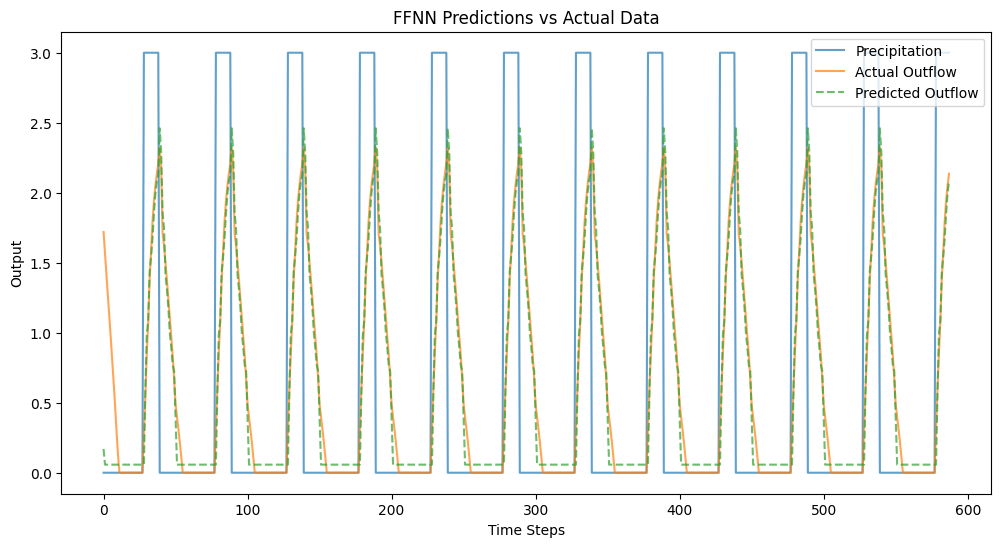

In [22]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Convert arrays to PyTorch tensors
x_input = torch.FloatTensor(network_precip_tensor.detach().numpy())
y_target = torch.FloatTensor(network_outflow_tensor_0.detach().numpy())

# Define the sequence length (you can adjust this)
seq_length = 12

# Function to create sequences
def create_sequences(input_data, target_data, seq_length):
    xs, ys = [], []
    for i in range(len(input_data) - seq_length):
        x_seq = input_data[i:i + seq_length]
        y_seq = target_data[i + seq_length]
        xs.append(x_seq)
        ys.append(y_seq)
    return torch.stack(xs), torch.stack(ys)

X, y = create_sequences(x_input, y_target, seq_length)

# Feedforward Neural Network Model
class FFNNModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size=3, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        # Define your feedforward layers here
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc4 = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        x = self.fc1(input_seq)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        predictions = self.fc4(x)
        return predictions[-1]

model = FFNNModel(input_size=seq_length)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    for seq, labels in zip(X, y):
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item()}')

print(f'Final loss: {single_loss.item()}')

predictions = []
model.eval()
with torch.no_grad():
    for seq in X:
        predictions.append(model(seq).item())
predictions_np = np.array(predictions)

plt.figure(figsize=(12, 6))
plt.title("FFNN Predictions vs Actual Data")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.plot(x_input.numpy()[seq_length:], label='Precipitation', alpha=0.7)
plt.plot(y_target.numpy()[seq_length:], label='Actual Outflow', alpha=0.7)
plt.plot(predictions_np, label='Predicted Outflow', alpha=0.7, linestyle='--')
plt.legend()
plt.show()